In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser
from mpl_toolkits.mplot3d import Axes3D


# a

In [2]:
date_parser = lambda dates: parser.parse(dates, dayfirst=True)
# date_parser = lambda dates: pd.datetime.strptime(dates, "%d-%m-%Y")
data_time  = pd.read_csv("SP500_weekly_Jan1988_Nov2018.csv",parse_dates = ["Date"], 
                         index_col='Date', date_parser=date_parser)

In [3]:
def plot_close(datas):
    plt.figure(figsize= (30,10))
    for data in datas:
        plt.plot(data)
    plt.grid()
    

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


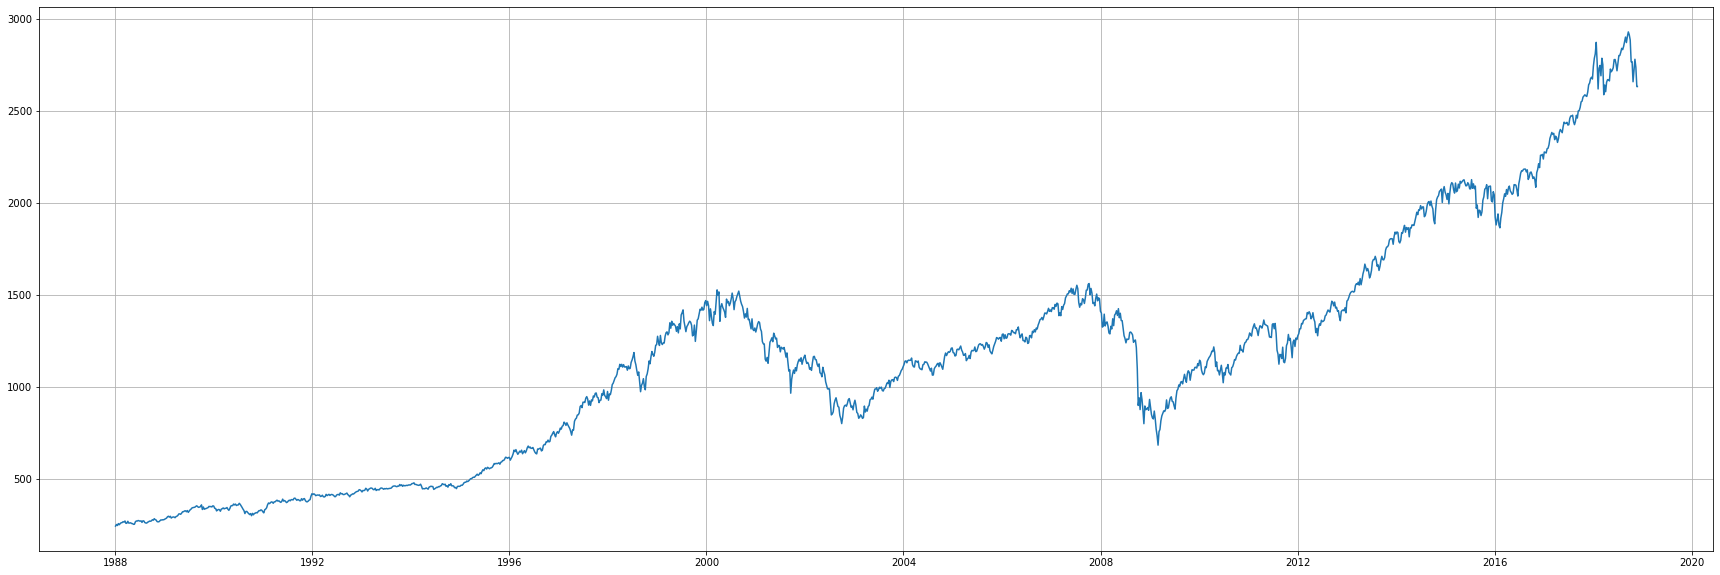

In [4]:
plot_close([data_time])

# b

In [5]:
data = pd.read_csv("SP500_weekly_Jan1988_Nov2018.csv")
data.index = data.index + 1
data = data["Adj Close"]


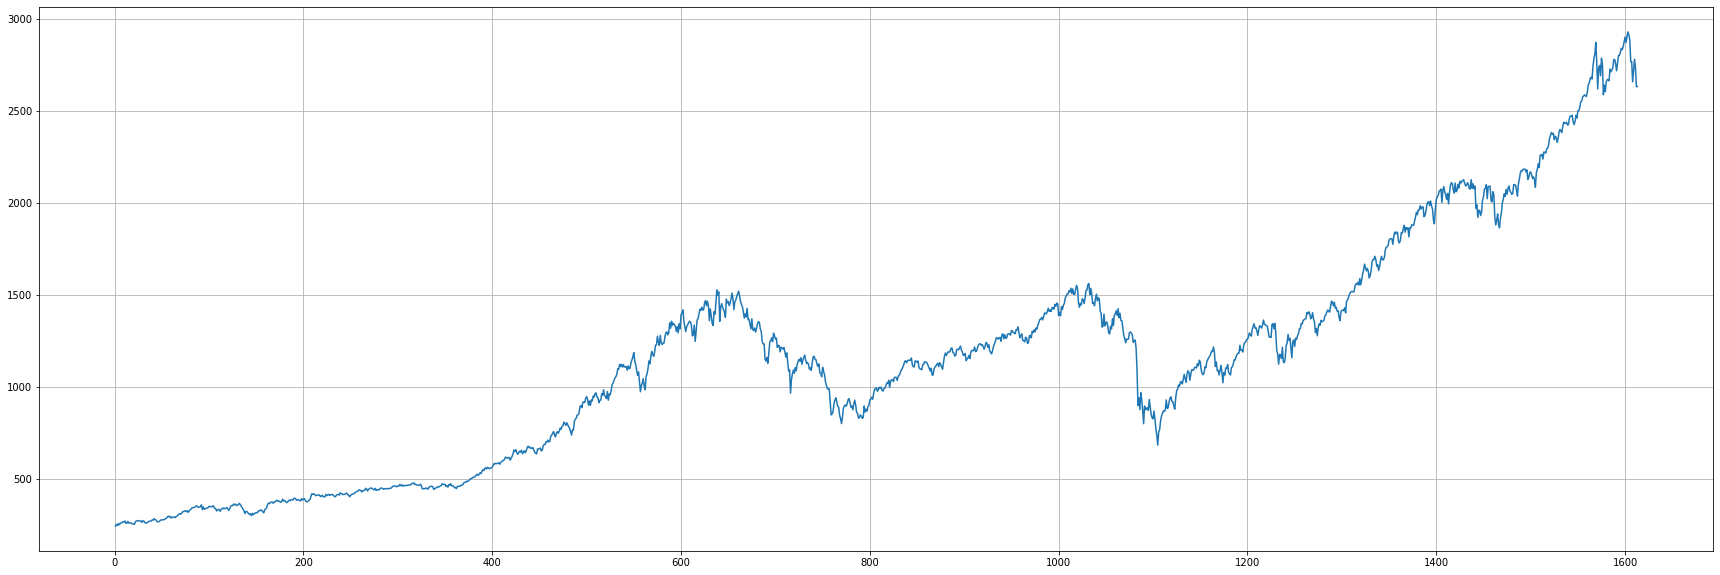

In [6]:
plot_close([data])

In [7]:
# def naive_drift(time_series,length):
#     """Naice forecast with drift
#     Allow the forecasts to increase or decrease over time, 
#     where the amount of change over time (called the drift) 
#     is set to be the average change seen in the historical data. 
    
#     Arg:
#         time_series: (pandas.Series)
#         length: (int)  
#     return:
#         s: (pandas.Series)
#     """
    
#     if length <= len(time_series):
#         y_init = time_series[1]
#         y_t = time_series[len(time_series) - length] # y1513

#         ts_changed = []

#         for i in range(length):
#             T = len(time_series) - length + i + 1
#             y_t = y_t + 1 * ((y_t - y_init) / (T - 1))
#             ts_changed.append(y_t)

#         s = pd.concat([time_series[:-length], pd.Series(ts_changed)])
#         s.index = range(1,len(s)+1)
#         return s
#     else:
#         print("")
        
        
        
def naive_drift(time_series):
    """Naice forecast with drift
    Allow the forecasts to increase or decrease over time, 
    where the amount of change over time (called the drift) 
    is set to be the average change seen in the historical data. 
    
    Arg:
        time_series: (pandas.Series)
        fore_len: (int)  
    return:
        s: (pandas.Series)
    """
    y_init = time_series[1]
    h = 1
    
    ts_changed = []

    for i in range(1, len(time_series)+1):
        T = i
        y_t = time_series[i]
        ts_changed.append(y_t + h * ((y_t - y_init) / (T - 1)))

    return pd.Series(ts_changed, index=time_series.index)

In [8]:
drift = naive_drift(data)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


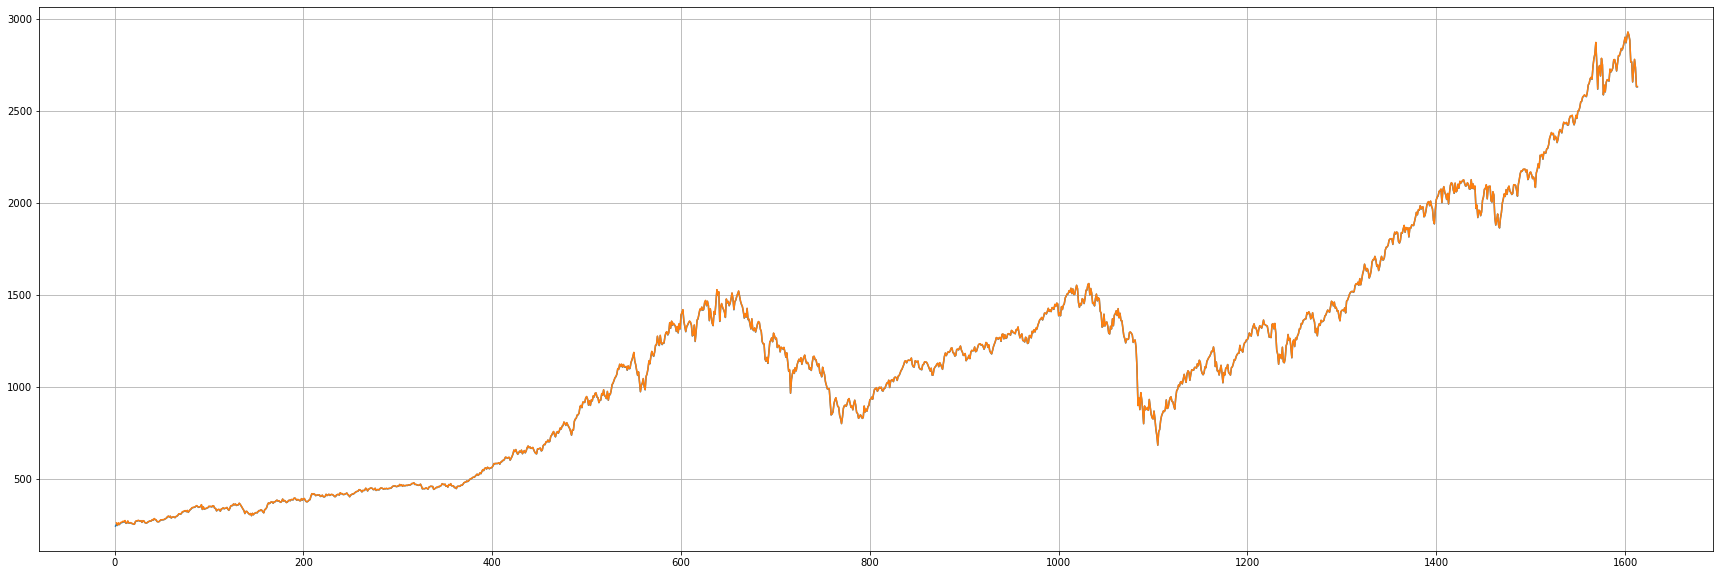

In [9]:
plot_close([data, drift])

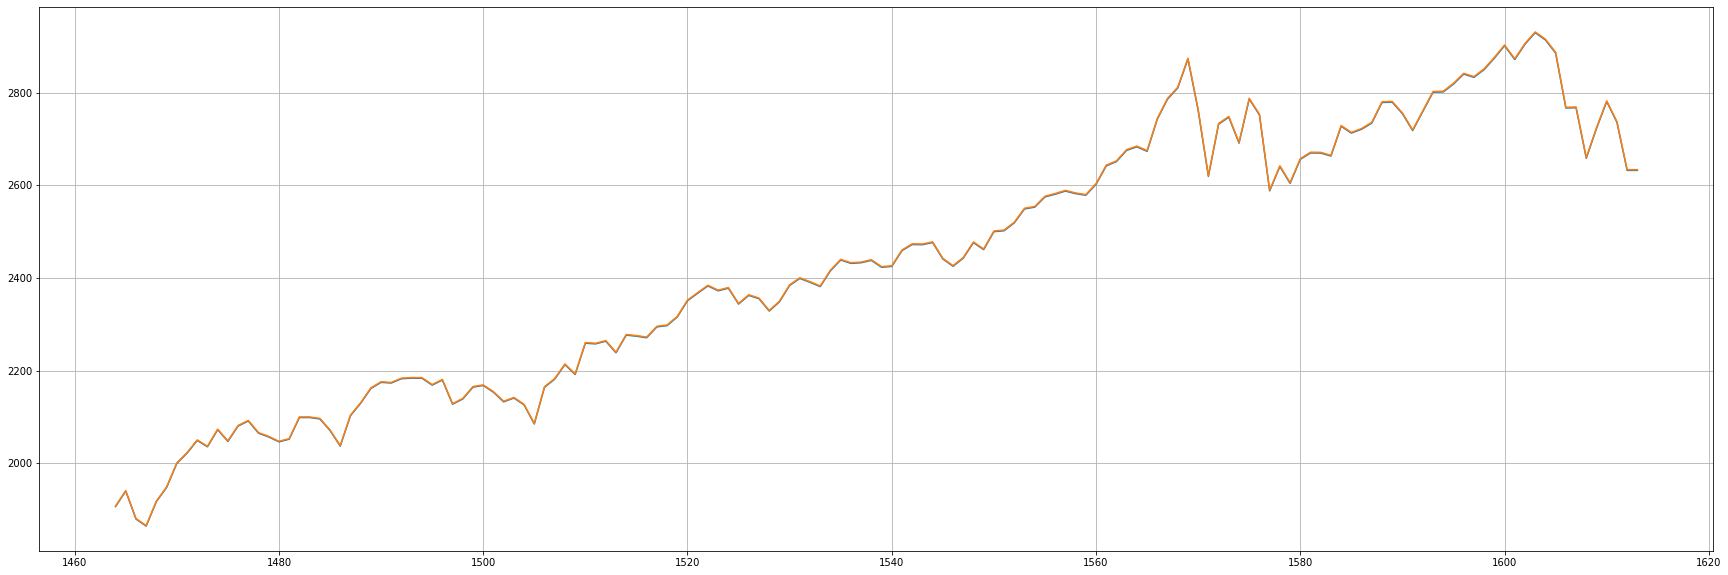

In [10]:
plot_close([data[-150:], drift[-150:]])

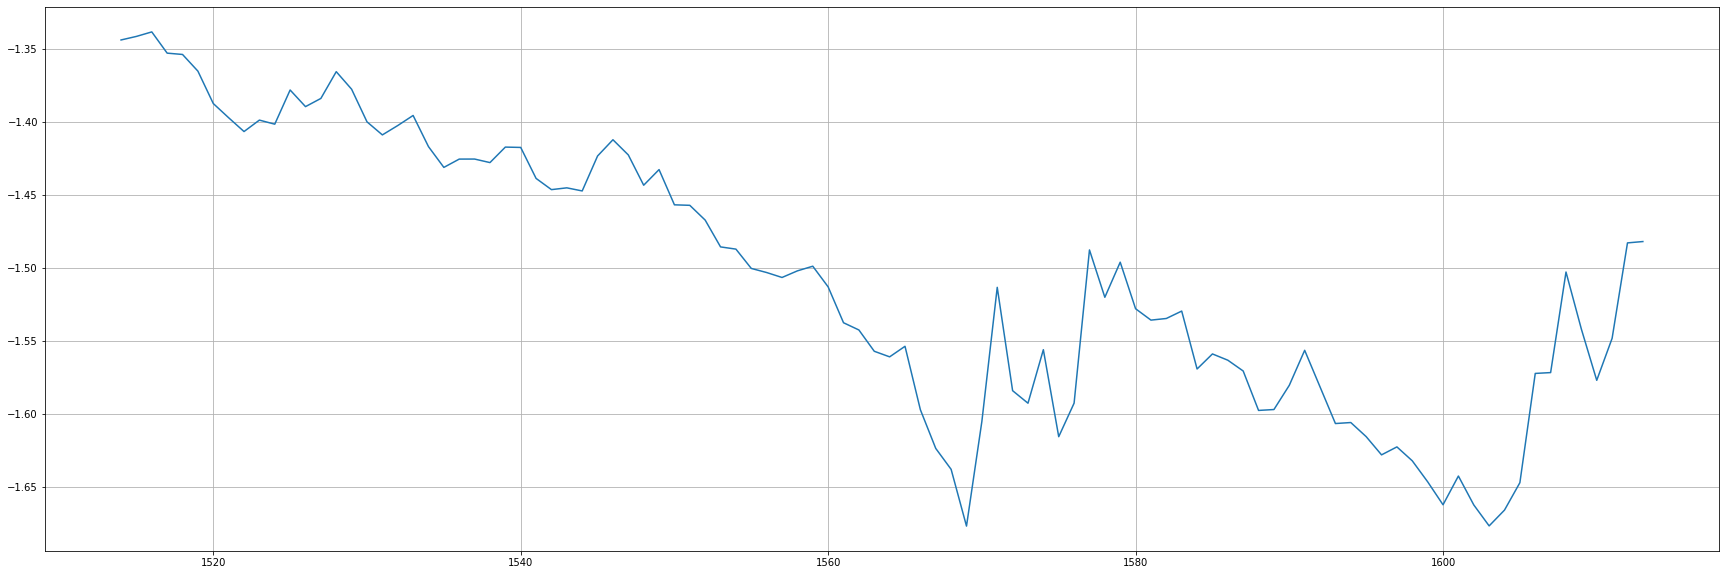

In [11]:
plot_close([(data - drift)[-100:]])

In [12]:
def rmse(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = [(y_true[i] - y_pred[i]) for i in range(len(y_true))]
    diff =  np.array(diff)[~np.isnan(diff)]
    mse = 0
    for i in range(len(diff)):
        mse += diff[i] ** 2
    return np.sqrt(mse/len(diff))


# def rmse(YT, Y_hat):
#     YT,Y_hat= np.array(YT),np.array(Y_hat)
#     return np.sqrt(np.mean((YT - Y_hat)**2))



def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
mean_absolute_percentage_error(data[-100:], drift[-100:])

0.05798827010463023

In [14]:
rmse(data[-100:], drift[-100:])

1.508882974328163

# c

In [15]:
def cma_n(ts,n):
    """
    """
    
    result = []
    if n % 2 == 0:
        for index in np.arange( n , len(ts)-n ):
#        print(index)
            sums = 0.5*(ts[index - n] + ts[index + n]) + ts[index - (n-1):index+n].sum() 
            mean = sums / 2 / n
            result.append(mean)
        
    nan = [np.nan]*n
    result = nan+result+nan
    return result

In [16]:
data.index = range(0, len(data))

#smoothed = pd.Series(cma_n(data,4), index = range(1, len(data)+1))
smoothed = pd.Series(data.rolling(2).mean().rolling(4).mean(), index = range(1, len(data)+1))

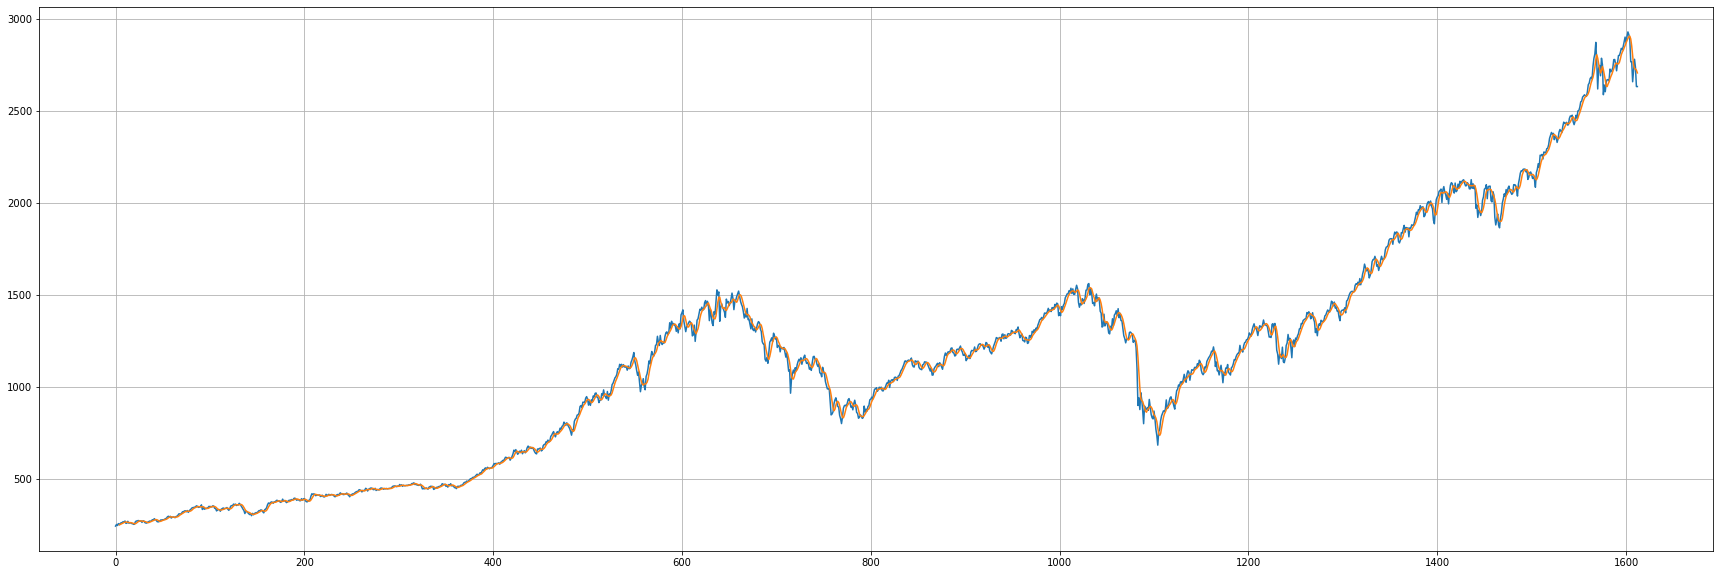

In [17]:
plot_close([data, smoothed])

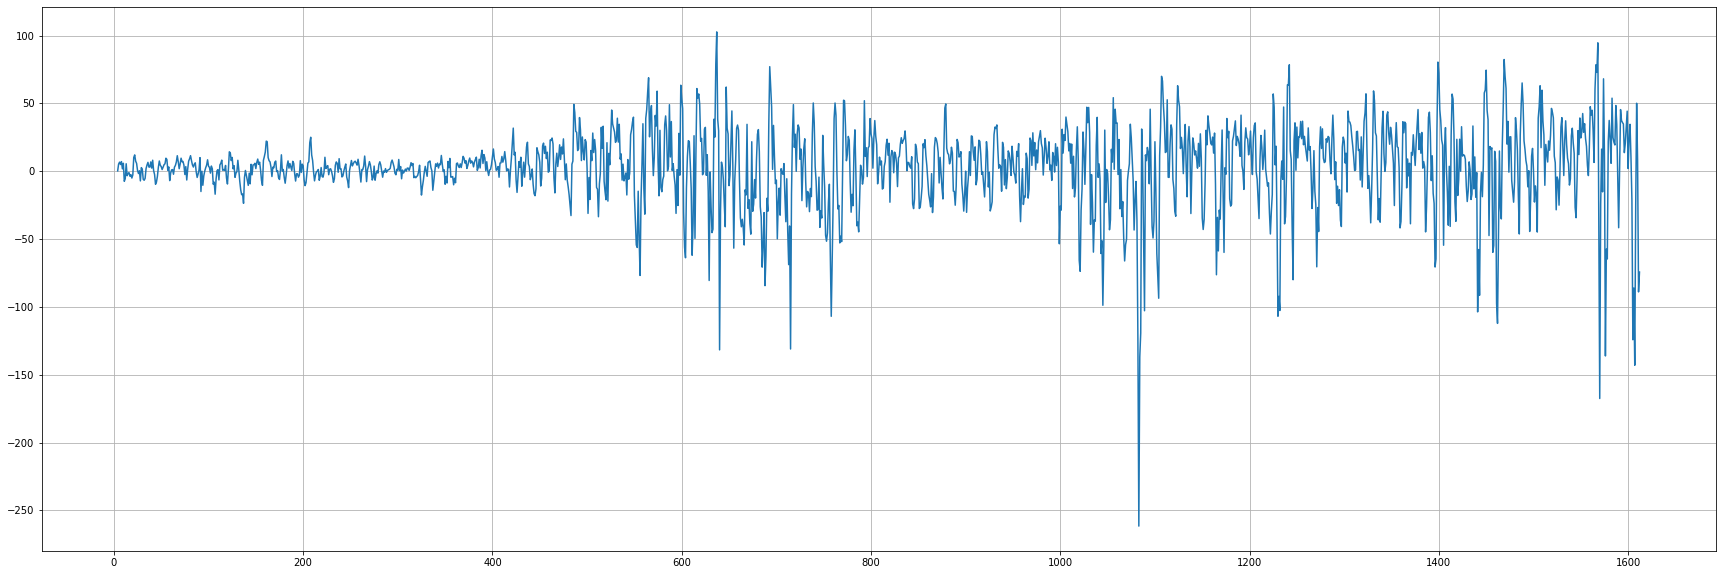

In [18]:
plot_close([data - smoothed])

# d

In [19]:
def returns(ts):
    """
    """
    r = []
    for i in range(len(ts)-1):
        temp = np.log(ts[i+1] / ts[i]) 
        r.append(temp)
    return pd.Series(r,index = range(1, len(r)+1))

In [20]:
data.index = range(0, len(data))
return_data = returns(data)

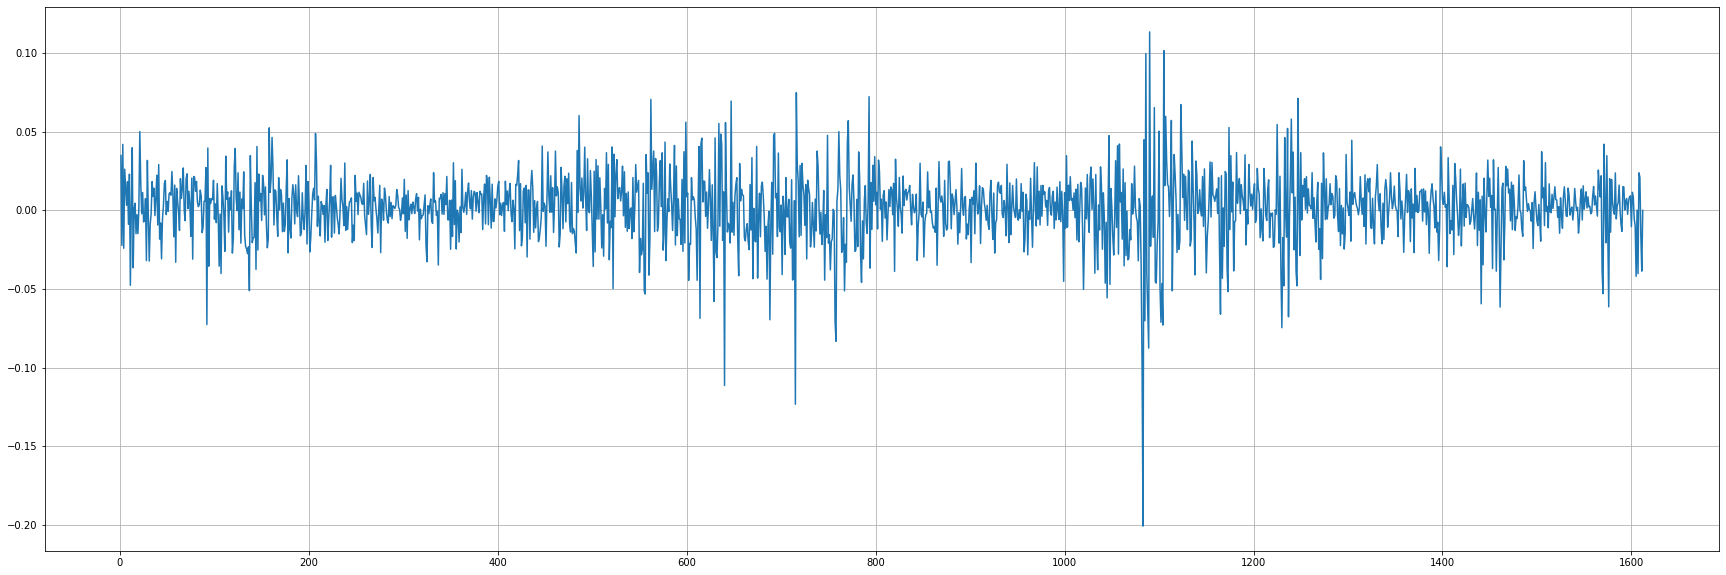

In [21]:
plot_close([return_data])

# e

In [22]:
def sse(x, y):
    return np.sum(np.power(x - y,2))

def sse_plot(sse):
    """
    """
    plt.figure()
    plt.plot(sse)
    plt.title("SSE for one step smoothing")
    plt.ylabel("SSE")
    plt.xlabel("Alpha")
    plt.xticks(np.linspace(0, 100, 11), ["{0:1.1f}".format(x) for x in np.linspace(0,1,11)])

def alpha_grid_search(train):
    sse_one = []
    alphas = np.arange(0.01,1,0.01)
    for i in alphas:
        smoothed = train.ewm(alpha = i, adjust=False).mean()
        sse_one.append(sse(smoothed[:-1], train.values[1:]))
        
    sse_plot(sse_one)
    
    optimal_alpha_one = alphas[np.argmin(sse_one)]
    print("Optimal Alpha for 1-step forecast is {0}".format(optimal_alpha_one))
    
    return optimal_alpha_one

# def ses_forecast(train, a, test):
#     """
#     """
#     smoothed = train.ewm(alpha=a, adjust=False).mean()

#     l_last = smoothed[len(smoothed)-1]
#     y_t = train[len(train)-1]
    
#     return pd.Series([a * y_t + (1 - a) * l_last] * len(test), index=test.index)
    
def ses_forecast(data, a, length):
    smoothed = data.ewm(alpha=a, adjust=False).mean()
    return smoothed[-length:]

Optimal Alpha for 1-step forecast is 0.91


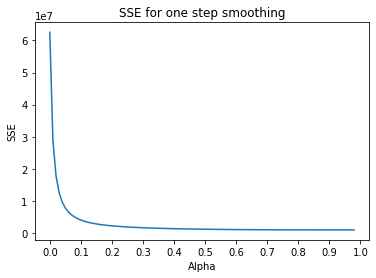

In [23]:
train = data[:-100]
test = data[-100:]

alpha = alpha_grid_search(train)

forecast = ses_forecast(data, alpha, length=len(test))

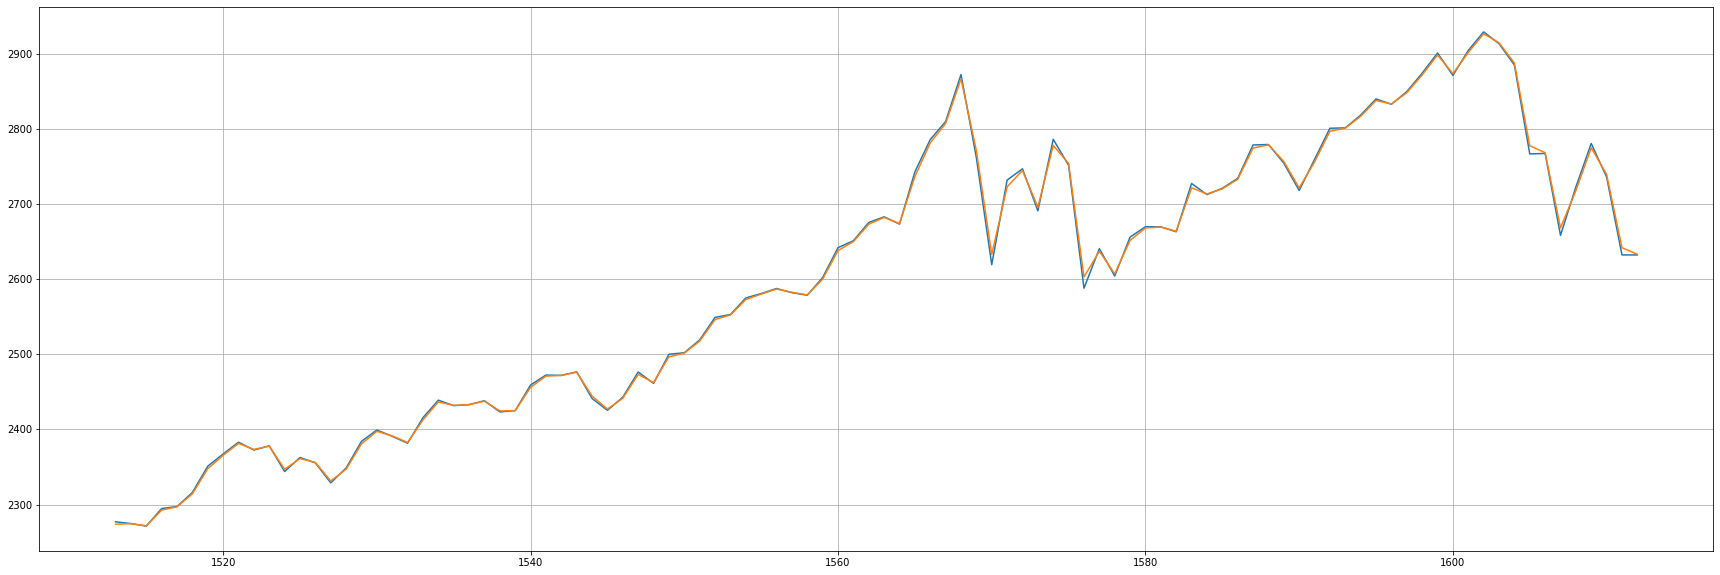

In [24]:
plot_close([test,forecast])

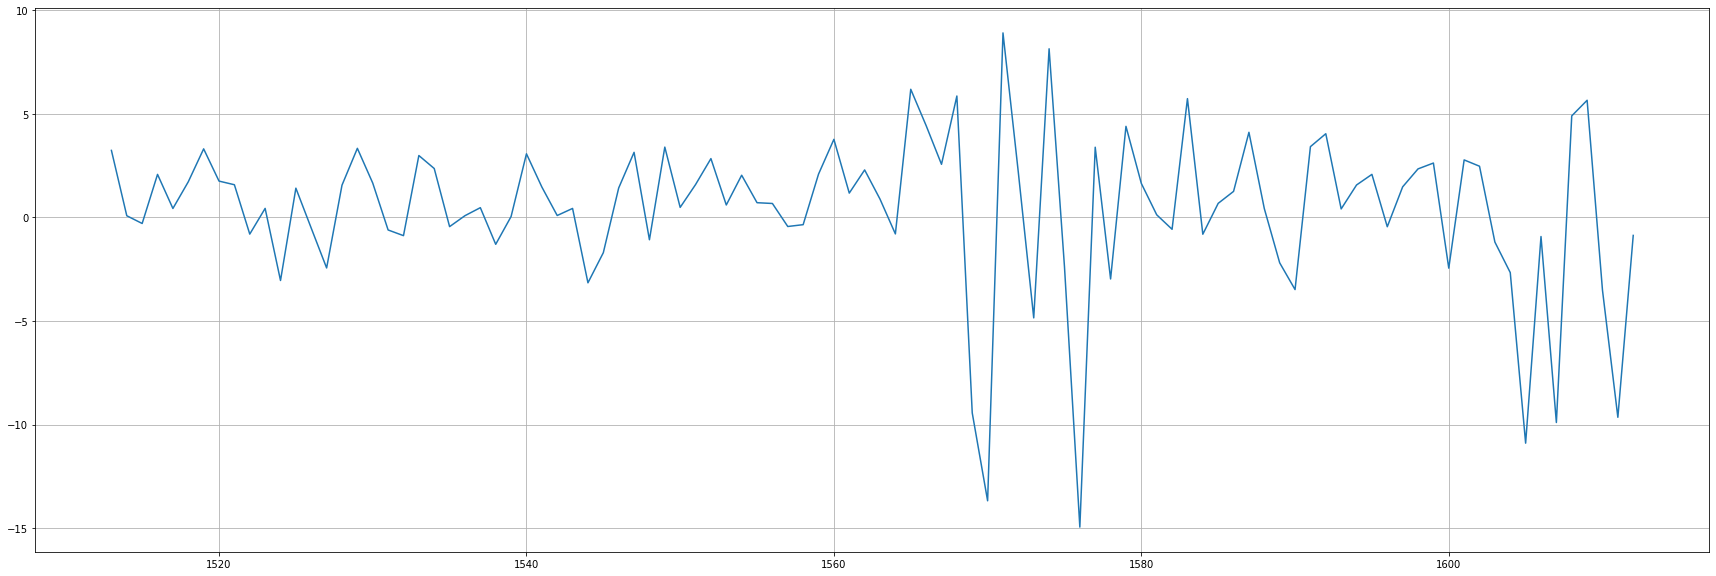

In [25]:
plot_close([test - forecast])

In [26]:
mean_absolute_percentage_error(test, forecast)

0.10236274556220219

# f

In [27]:
return_square = return_data ** 2
train = return_square[:-100]
test = return_square[-100:]

Optimal Alpha for 1-step forecast is 0.11


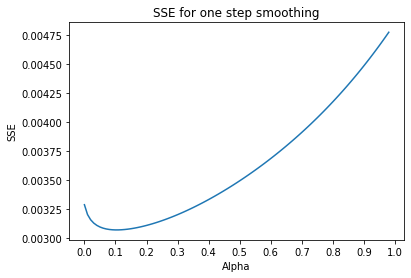

In [28]:
alpha = alpha_grid_search(train)

forecast = ses_forecast(return_square, alpha, length=len(test))

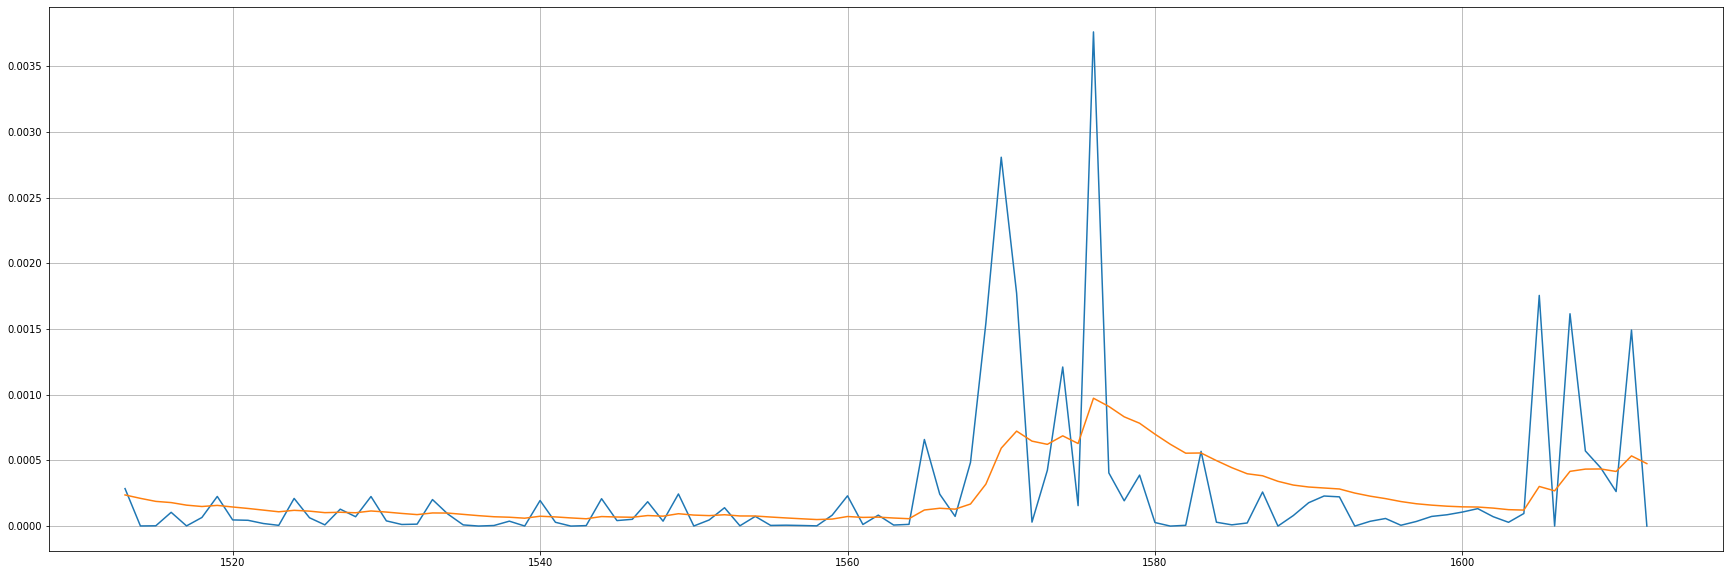

In [29]:
plot_close([test,forecast])

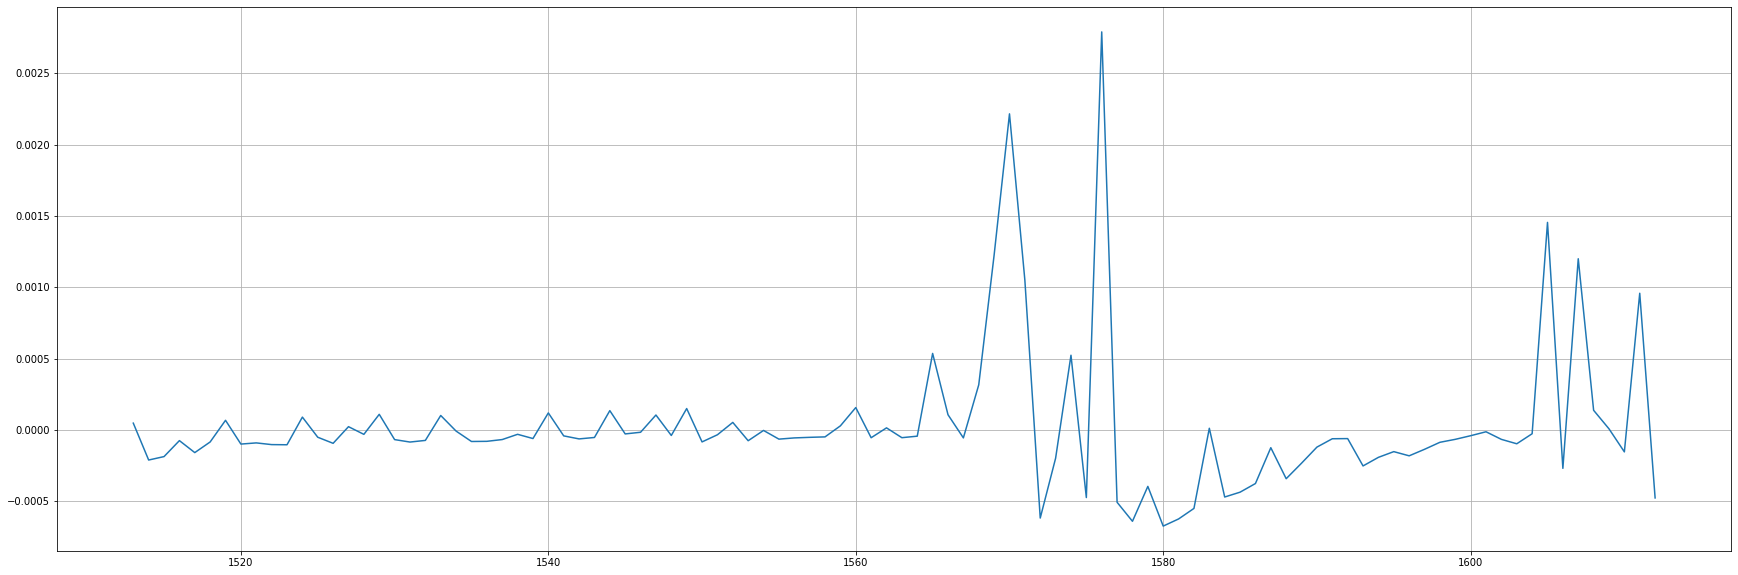

In [30]:
plot_close([test - forecast])

In [31]:
# mean_absolute_percentage_error(test, forecast)

# h

In [32]:
def holt(y, alpha, beta, length):
    """
    
    """
    
#    l = [ y[:12].mean() ]
    l = [y[0]]
#    b = [ (sum(y[12:24])-sum(y[:12]))/144 ]
    b = [y[1] - y[0]]

    holtsmoothed = []
    
    Y = y.tolist()
    
    for i in range(len(Y) + length): 
        if i == len(Y) - 1:
            Y.append(l[-1] + b[-1])
            
        l.append(alpha * Y[i] + (1 - alpha) * (l[i] + b[i]))
        b.append(beta * (l[i+1] - l[i]) + (1 - beta) * b[i])
        holtsmoothed.append(l[i] + b[i])
    
    return holtsmoothed

def sse_plot_3d(sse_one, alpha, beta):
    """
    """
    
    fig=plt.figure(figsize= (30,30))
    ax=Axes3D(fig)
    X,Y=np.meshgrid(np.arange(0.01,1,0.01),np.arange(0.01,1,0.01))
    Z = np.array(sse_one).reshape((99,99))
    ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=plt.get_cmap('rainbow'))
    
    x1 = alpha
    y1 = beta
    z1 = Z[int(alpha * 100)-1, int(beta * 100)-1]
    ax.scatter(x1,y1,z1,c='r',marker="v")


def paras_grid_search(train):
    """
    """
    
    sse_one = []
    for alpha in np.arange(0.01,1,0.01):        
        for beta in np.arange(0.01,1,0.01):
            smoothed = holt(train,alpha,beta,length=0)
            temp_sse = sse(smoothed[1:], train.values[1:])
            sse_one.append(temp_sse)
        
    
    
    alpha = (np.argmin(sse_one) / 99 + 1) * 0.01
    beta = (np.argmin(sse_one) % 99 + 1) * 0.01
    
    sse_plot_3d(sse_one, alpha, beta)
    
    print("Optimal Alpha for 1-step forecast is {0}".format(alpha))
    print("Optimal Beta for 1-step forecast is {0}".format(beta))
    
    return alpha, beta
    


## e

In [ ]:
train = data[:-100]
test = data[-100:]
alpha, beta = paras_grid_search(train)
forecast = pd.Series(holt(train, alpha, beta, len(test)), index = data.index)

In [ ]:
plot_close([data, forecast])

In [ ]:
plot_close([data - forecast])

In [ ]:
plot_close([data[-len(test):], forecast[-len(test):]])

In [ ]:
plot_close([data[-len(test):] - forecast[-len(test):]])

In [ ]:
mean_absolute_percentage_error(test, forecast[-len(test):])

## f

In [ ]:
return_square.index = range(len(return_square))

In [ ]:
train = return_square[:-100]
test = return_square[-100:]

alpha, beta = paras_grid_search(train)
forecast = pd.Series(holt(train, alpha, beta, len(test)), index=return_square.index)

In [ ]:
plot_close([return_square, forecast])

In [ ]:
plot_close([return_square - forecast])

In [ ]:
plot_close([return_square[-len(test):], forecast[-len(test):]])

In [ ]:
plot_close([return_square[-len(test):] - forecast[-len(test):]])

In [ ]:
# mean_absolute_percentage_error(test, forecast[-len(test):])